In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
%matplotlib inline

In [2]:
import os
import re
print(os.getcwd())

C:\Users\ASUS_AMZAD


In [3]:
import tensorflow as tf

In [4]:
tf .__version__

'2.3.1'

In [5]:
df = pd.read_csv('C:/Users/ASUS_AMZAD/Desktop/Major/Dataset1/data.csv')
df.head()

URLs  \
0  http://www.bbc.com/news/world-us-canada-414191...   
1  https://www.reuters.com/article/us-filmfestiva...   
2  https://www.nytimes.com/2017/10/09/us/politics...   
3  https://www.reuters.com/article/us-mexico-oil-...   
4  http://www.cnn.com/videos/cnnmoney/2017/10/08/...   

                                            Headline  \
0         Four ways Bob Corker skewered Donald Trump   
1  Linklater's war veteran comedy speaks to moder...   
2  Trump’s Fight With Corker Jeopardizes His Legi...   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...   
4        Jason Aldean opens 'SNL' with Vegas tribute   

                                                Body  Label  
0  Image copyright Getty Images\nOn Sunday mornin...      1  
1  LONDON (Reuters) - “Last Flag Flying”, a comed...      1  
2  The feud broke into public view last week when...      1  
3  MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1  
4  Country singer Jason Aldean, who was performin...      1

In [6]:
df=df.dropna()

In [7]:
x=df.drop('Label',axis=1)

In [8]:
y=df['Label']

In [9]:
x.ndim

2

In [10]:
x.shape

(3988, 3)

In [11]:
y.ndim

1

In [12]:
y.shape

(3988,)

In [13]:
y = y.values.reshape(-1,1)

In [14]:
y.ndim

2

In [15]:
x.ndim

2

In [16]:
voc_size=5000

In [17]:
messages=x.copy()

In [18]:
messages.reset_index(inplace=True)

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS_AMZAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
cong_text = ' '.join(df[df['Label'] ==0]['Headline'])
incong_text = ' '.join(df[df['Label'] ==1]['Headline'])
incong_words = [word for word in nltk.tokenize.word_tokenize(incong_text) if word not in stopwords.words('english') and len(word)>3]
cong_words = [word for word in nltk.tokenize.word_tokenize(cong_text) if word not in stopwords.words('english') and len(word)>3]

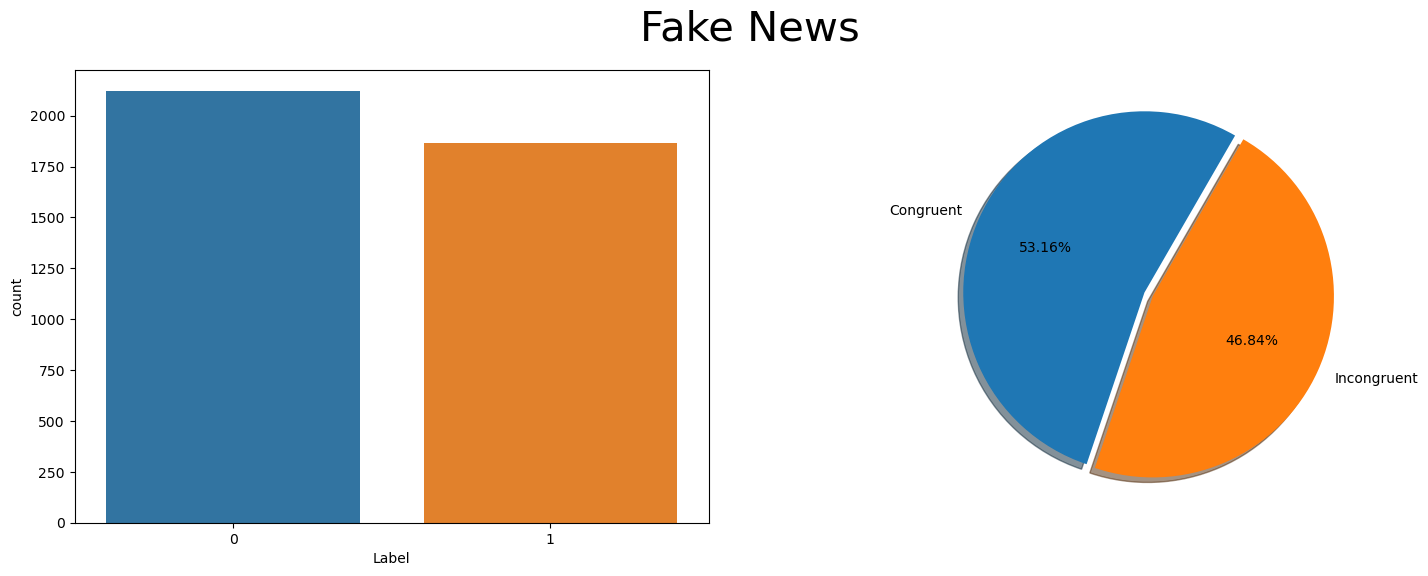

In [21]:
### Displaying Target Distribution

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18,6), dpi=100)
sns.countplot(df['Label'], ax=axes[0])
axes[1].pie(df['Label'].value_counts(),
           labels=['Congruent','Incongruent'],
           autopct='%1.2f%%',
           shadow=True,
           explode=(0.05,0),
           startangle=60)
fig.suptitle('Fake News', fontsize=30)
plt.show()

In [22]:
### Body text Dataset Preprocessing

from nltk.stem.porter import PorterStemmer
porst = PorterStemmer()
corpus_b = []
for i in range (0,len(messages)):
    print(i)
    review_b = re.sub('[^a-z A-Z]','',messages['Body'][i])
    review_b = review_b.lower()
    review_b = review_b.split()
    
    review_b = [porst.stem(word) for word in review_b if not word in stopwords.words('english')]
    review_b = ' '.join(review_b)
    corpus_b.append(review_b)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


In [ ]:
corpus_b

In [27]:
from tensorflow.keras.preprocessing.text import one_hot

In [28]:
onehot_repr = [one_hot(words,voc_size)for words in corpus_b]
onehot_repr

[[3616,
  685,
  4809,
  2512,
  3708,
  3725,
  3431,
  394,
  4743,
  3161,
  4062,
  2680,
  4951,
  4923,
  3102,
  906,
  4115,
  46,
  315,
  1796,
  4993,
  3605,
  4680,
  1861,
  1250,
  1796,
  3892,
  1043,
  1874,
  1739,
  156,
  465,
  2414,
  4317,
  3356,
  4963,
  165,
  1127,
  1712,
  3356,
  566,
  1181,
  4829,
  4273,
  1081,
  1442,
  1021,
  2873,
  165,
  2240,
  4993,
  2647,
  4060,
  2502,
  2980,
  818,
  2873,
  165,
  2057,
  2233,
  1758,
  2388,
  1202,
  3365,
  3442,
  2873,
  165,
  2534,
  1742,
  4641,
  1202,
  3187,
  2588,
  2316,
  3173,
  3161,
  2003,
  1792,
  3413,
  2399,
  2849,
  3784,
  3208,
  1914,
  2447,
  859,
  2238,
  4425,
  4410,
  2171,
  3725,
  3356,
  4963,
  165,
  1792,
  2242,
  4533,
  2971,
  3294,
  2846,
  3018,
  2336,
  1270,
  1796,
  826,
  2509,
  4993,
  1157,
  2759,
  626,
  4317,
  3356,
  2443,
  1796,
  1874,
  2589,
  4255,
  3099,
  4993,
  4014,
  1818,
  1934,
  3099,
  4609,
  3099,
  417,
  4988,
  8

In [29]:
sent_len = 50
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_len)
print(embedded_docs)

[[2849 4290 4183 ... 4993 3972 3988]
 [1021   59 3146 ... 1897 3938 1955]
 [1004 3530  394 ... 2301 4821 4567]
 ...
 [   0    0    0 ... 1290 3571 1317]
 [2799 1384  666 ... 4074 2714 4105]
 [4070 3852 1771 ... 1825 4955 3611]]


In [30]:
len(embedded_docs)

3988

In [31]:
embedded_docs[0]

array([2849, 4290, 4183, 2728, 4719, 2269,  143, 1902,  898, 3402, 1227,
       2379, 1578, 3375, 3603,  875,  921, 1089, 2846, 2873, 4535, 1992,
       2397, 2832, 4505, 2265, 4993,  630, 4491,  838,   53,  935, 2138,
       2098, 1094, 3161, 2813,  165, 3046,  156,  227,  177, 1532, 1934,
       4080, 2264,  813, 4993, 3972, 3988])

In [32]:
### Headline Dataset Preprocessing

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus_h = []
for i in range (0,len(messages)):
    print(i)
    review_h = re.sub('[^a-z A-Z]','',messages['Headline'][i])
    review_h = review_h.lower()
    review_h = review_h.split()
    
    review_h = [ps.stem(word) for word in review_h if not word in stopwords.words('english')]
    review_h = ' '.join(review_h)
    corpus_h.append(review_h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109


3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750


In [33]:
corpus_h

['four way bob corker skewer donald trump',
 'linklat war veteran comedi speak modern america say star',
 'trump fight corker jeopard legisl agenda',
 'egypt cheiron win tieup pemex mexican onshor oil field',
 'jason aldean open snl vega tribut',
 'jetnat fanduel leagu week',
 'kansa tri tax plan similar trump fail',
 'india rbi chief growth import cost inflat newspap',
 'epa chief sign rule clean power plan exit tuesday',
 'talk sale air berlin plane easyjet risk collaps report',
 'us presid donald trump quietli sign law allow warrantless search part va dc md',
 'fantasi footbal team defens rank week',
 'shut play damn basebal',
 'deloitt cyber attack affect client guardian',
 'chuck axe hbd brickyard adam moonlight ace chuck season final',
 'gunman girlfriend said didnt know plan harm',
 'maril danley gunman girlfriend say unawar plan',
 'trump immigr rhetor echo bitter fight',
 'trump bemoan littl appreci san juan mayor beg water',
 'meet militari trump talk calm storm',
 'teacher s

In [34]:
onehot_repr = [one_hot(words,voc_size)for words in corpus_h]
onehot_repr

[[1157, 17, 4963, 165, 4205, 3431, 394],
 [4744, 124, 2357, 2810, 4304, 4784, 1315, 2646, 1934],
 [394, 2450, 165, 4381, 1809, 4082],
 [12, 4227, 1627, 3503, 75, 334, 4290, 2668, 1728],
 [3672, 4064, 3536, 1002, 24, 1274],
 [3380, 3941, 1768, 4111],
 [312, 143, 2458, 3983, 270, 394, 190],
 [859, 705, 3373, 916, 2886, 1404, 1222, 4490],
 [2860, 3373, 4086, 4654, 4230, 1712, 3983, 2312, 4789],
 [4020, 206, 3591, 1933, 2739, 3703, 3053, 587, 2889],
 [766,
  4993,
  3431,
  394,
  4865,
  4086,
  1179,
  4871,
  3514,
  2293,
  2168,
  4701,
  474,
  3283],
 [2671, 2155, 4183, 2840, 1731, 4111],
 [3276, 1536, 990, 3572],
 [2934, 4328, 1043, 4289, 3818, 3147],
 [1366, 488, 3520, 4081, 2413, 1756, 4758, 1366, 3360, 3369],
 [3992, 1565, 1021, 2588, 3099, 3983, 3616],
 [114, 3388, 3992, 1565, 2646, 3223, 3983],
 [394, 686, 4680, 4227, 3690, 2450],
 [394, 2628, 3816, 3455, 3400, 1527, 2032, 2240, 2999],
 [2873, 923, 394, 4020, 626, 1704],
 [1803, 3989, 1266, 1871, 1435, 4692, 1381, 1251],
 [102

In [35]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 4205 3431  394]
 [   0    0    0 ... 1315 2646 1934]
 [   0    0    0 ... 4381 1809 4082]
 ...
 [   0    0    0 ... 2502 4944 1617]
 [   0    0    0 ... 4914 4596 3006]
 [   0    0    0 ... 4070  319 2910]]


In [36]:
len(embedded_docs)

3988

In [37]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 1157,   17, 4963,  165, 4205, 3431,  394])

In [38]:
df = df[['Headline','Label']]
df.head()

Headline  Label
0         Four ways Bob Corker skewered Donald Trump      1
1  Linklater's war veteran comedy speaks to moder...      1
2  Trump’s Fight With Corker Jeopardizes His Legi...      1
3  Egypt's Cheiron wins tie-up with Pemex for Mex...      1
4        Jason Aldean opens 'SNL' with Vegas tribute      1

In [39]:
#Filtering headlines

df['Headline'] = df['Headline'].apply(lambda x: x.lower())
df['Headline'] = df['Headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [40]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['Headline'].values)
X = tokenizer.texts_to_sequences(df['Headline'].values)
X = pad_sequences(X)

In [41]:
Y = pd.get_dummies(df['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2671, 85) (2671, 2)
(1317, 85) (1317, 2)


In [42]:
##Creating the AHRDE Model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
len(embedded_docs),y.shape

(3988, (3988, 1))

In [44]:
import numpy as np
x_final=np.array(embedded_docs)
y_final=np.array(y)

In [45]:
x_final.shape,y_final.shape

((3988, 20), (3988, 1))

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final,  random_state=42)

In [47]:
## AHRDE Model Training
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=10, batch_size=64)

Epoch 1/10
47/47 [==============================] - 1s 21ms/step - loss: 0.6633 - accuracy: 0.6085 - val_loss: 0.5670 - val_accuracy: 0.7663
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4527 - accuracy: 0.8191 - val_loss: 0.4510 - val_accuracy: 0.7934
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2659 - accuracy: 0.9007 - val_loss: 0.4268 - val_accuracy: 0.8124
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1563 - accuracy: 0.9425 - val_loss: 0.4406 - val_accuracy: 0.8154
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0918 - accuracy: 0.9686 - val_loss: 0.7387 - val_accuracy: 0.7914
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0883 - accuracy: 0.9776 - val_loss: 0.5559 - val_accuracy: 0.8195
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0525 - accuracy: 0.9846 - val_loss: 0.4244 - val_accuracy: 0.8205
Epoch 8/10
47

In [48]:
y_test.ndim

2

In [49]:
y_train.ndim

2

In [51]:
## Performance Metrices And Accuracy
y_pred=model.predict_classes(x_test)

In [52]:
from sklearn.metrics import confusion_matrix,  f1_score

In [53]:
confusion_matrix(y_test, y_pred)

array([[460, 100],
       [ 81, 356]], dtype=int64)

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred)

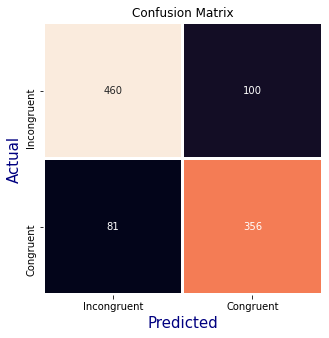

In [55]:
## confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Incongruent','Congruent'], yticklabels = ['Incongruent','Congruent'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15);

In [56]:
confusion_matrix(y_test, y_pred, labels=(1,0)).ravel()

array([356,  81, 100, 460], dtype=int64)

In [57]:
tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=(1,0)).ravel()

In [58]:
precision = tp/(tp+fp)
precision

0.7807017543859649

In [59]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.7973124300111982

In [60]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.8146453089244852

In [61]:
from sklearn.metrics import accuracy_score

In [62]:
# accuracy of the model before applying the IT
accuracy_score(y_test, y_pred)

0.8184553660982948

In [63]:
model.metrics_names

['loss', 'accuracy']

<ipython-input-68-ee9a1527a465>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


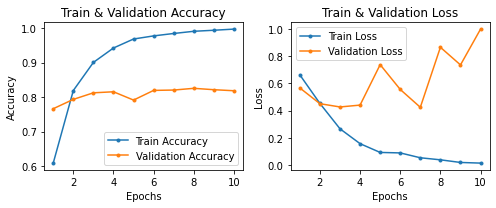

In [68]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['accuracy']) + 1,1)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    fig , ax = plt.subplots(1,2, figsize=(7,3))
    ax[0].plot(epochs , train_acc , '.-' , label ='Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs , train_loss , '.-', label ='Train Loss')
    ax[1].plot(epochs , val_loss , '.-', label ='Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()

plot_loss_epochs(history)

In [69]:
# for text processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [70]:
data = pd.read_csv('C:/Users/ASUS_AMZAD/Downloads/data.csv.zip')
data.head()

URLs  \
0  http://www.bbc.com/news/world-us-canada-414191...   
1  https://www.reuters.com/article/us-filmfestiva...   
2  https://www.nytimes.com/2017/10/09/us/politics...   
3  https://www.reuters.com/article/us-mexico-oil-...   
4  http://www.cnn.com/videos/cnnmoney/2017/10/08/...   

                                            Headline  \
0         Four ways Bob Corker skewered Donald Trump   
1  Linklater's war veteran comedy speaks to moder...   
2  Trump’s Fight With Corker Jeopardizes His Legi...   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...   
4        Jason Aldean opens 'SNL' with Vegas tribute   

                                                Body  Label  
0  Image copyright Getty Images\nOn Sunday mornin...      1  
1  LONDON (Reuters) - “Last Flag Flying”, a comed...      1  
2  The feud broke into public view last week when...      1  
3  MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1  
4  Country singer Jason Aldean, who was performin...      1

In [71]:
data.shape

(4009, 4)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


In [73]:
# dropping rows where there is any null value
data.dropna(inplace=True, axis=0)

# taking only the name of website from the URLs
pattern = 'https?://([\w.]+)/'
data['Website'] = data.URLs.str.extract(pattern)
data.drop('URLs', axis=1, inplace=True)

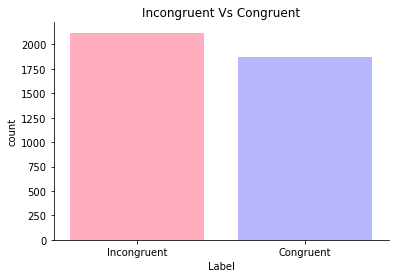

In [75]:
# making a bar plot to count the frequency of Incongruent Vs Congruent
sns.countplot(x='Label', 
              data=data,
              palette=['#ffaec0', '#b8b5ff'],
              saturation=1)
sns.despine()
plt.xticks([0,1], ['Incongruent', 'Congruent'])
plt.title('Incongruent Vs Congruent');

In [76]:
incongruent_news_count = data[data.Label == 1]['Website'].value_counts()
congruent_news_count = data[data.Label == 0]['Website'].value_counts()

In [77]:
fdf = pd.DataFrame({
    'Web':incongruent_news_count.index,
    'Incongruent':incongruent_news_count.values
})

rdf = pd.DataFrame({
    'Web':congruent_news_count.index,
    'Congruent':congruent_news_count.values
})

In [78]:
rf_count = pd.merge(rdf, fdf, on='Web', how='outer').fillna(0)
rf_count['Congruent'] = rf_count['Congruent'].astype(int)
rf_count['Incongruent'] = rf_count['Incongruent'].astype(int)
rf_count

Web  Congruent  Incongruent
0           beforeitsnews.com       1681            0
1        www.activistpost.com        267            0
2           dailybuzzlive.com         99            0
3             www.disclose.tv         71            0
4             www.reuters.com          0          646
5                 www.cnn.com          0          389
6             www.nytimes.com          0          341
7                 www.bbc.com          0          333
8              abcnews.go.com          0           57
9               money.cnn.com          0           49
10            edition.cnn.com          0           15
11           inhealth.cnn.com          0           14
12              www.bbc.co.uk          0           10
13         bleacherreport.com          0            8
14              clarivate.com          0            3
15  thelab.bleacherreport.com          0            1
16                reuters.com          0            1
17                     cnn.it          0            1

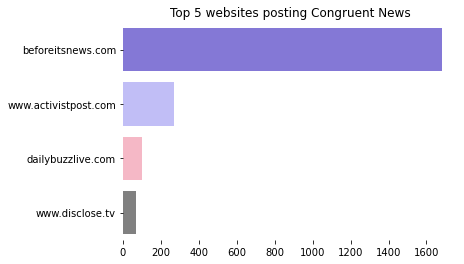

In [79]:
sns.barplot(y=congruent_news_count[:5].index, x=congruent_news_count[:5].values, 
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting Congruent News');

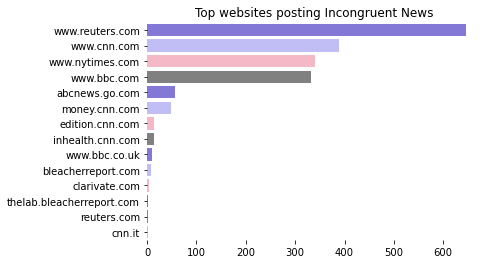

In [80]:
sns.barplot(y=incongruent_news_count.index, x=incongruent_news_count.values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey'])
sns.despine(bottom=True, left=True)
plt.title('Top websites posting Incongruent News');

In [81]:
lm = WordNetLemmatizer()
def clean_text(column):
    corpus = []
    for value in column:
        value = value.lower()
        value = re.sub('[^a-z]', ' ', value)
        value = value.split()
        
        # lemmatizing those words which are not stop words
        value = [lm.lemmatize(word) for word in value\
                 if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(value))
    return corpus 

# taking both headline and body of news into a single column
data['Text'] = data['Headline'] + ' ' + data['Body']
data['Text'] = clean_text(data.Text)

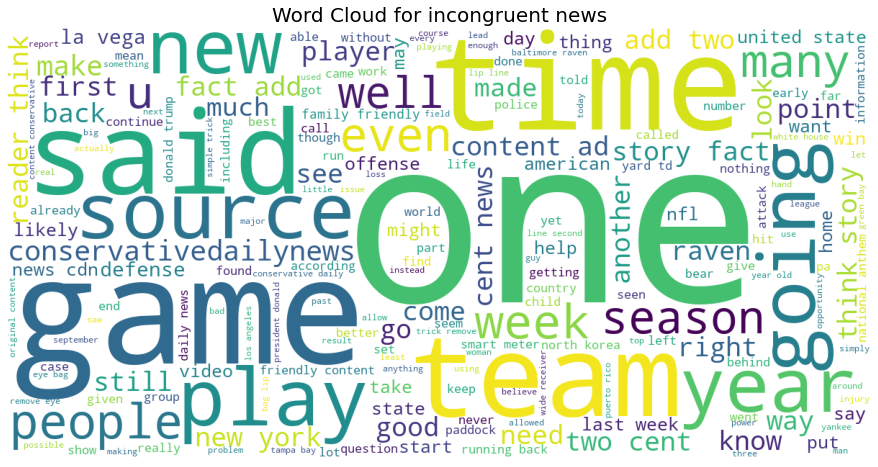

In [82]:
# Word Cloud for incongruent news
from wordcloud import WordCloud, STOPWORDS
sw = set(STOPWORDS)

incongruent_news = data[data.Label == 0]
congruent_news = data[data.Label == 1]

incongruent_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(incongruent_news.Text)) 
                     
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(incongruent_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for incongruent news', fontsize=20);

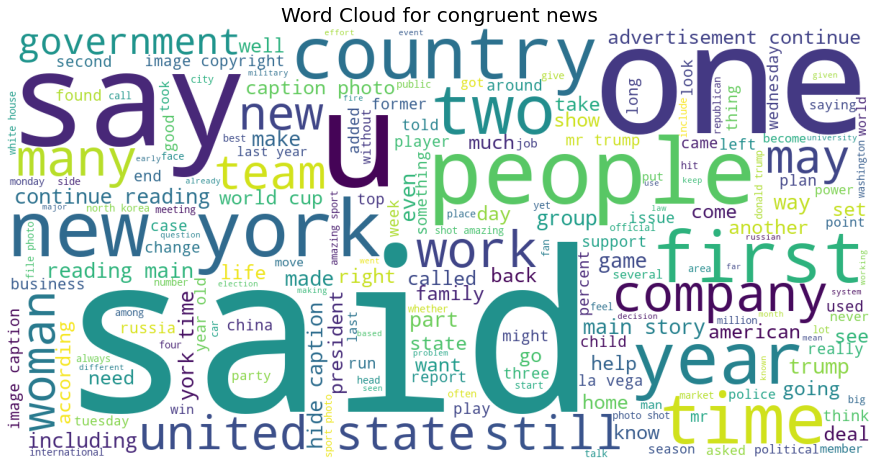

In [83]:
# Word Cloud for congruent news
congruent_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(congruent_news.Text)) 
                         
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(congruent_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for congruent news', fontsize=20);

In [84]:
# one hot representation of words
oh_repr = [one_hot(words, 5000) for words in data.Text]

In [85]:
# list to store length of words in each news
len_list = []
for w in data.Text:
    w = w.split()
    len_list.append(len(w))

print('Summary of word length :')
pd.Series(len_list).describe()

Summary of word length :


count    3988.000000
mean      289.271063
std       289.423529
min        10.000000
25%        65.000000
50%       217.000000
75%       419.000000
max      3171.000000
dtype: float64

In [86]:
sent_length = 400
embedded_doc = pad_sequences(oh_repr, padding='pre', maxlen=sent_length)
embedded_doc[:5]

array([[1235, 4464,  811, ..., 4122,  836, 3988],
       [   0,    0,    0, ..., 1781, 3938,  783],
       [ 701, 1586, 3244, ..., 2301, 4574, 4567],
       [   0,    0,    0, ...,  706,  189, 4136],
       [   0,    0,    0, ...,  520,   85, 2915]])

In [88]:
# initializing ERE model

model = Sequential()
model.add(Embedding(5000, 100, input_length=sent_length))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 100)          500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 650,751
Trainable params: 650,751
Non-trainable params: 0
_________________________________________________________________


In [89]:
from sklearn.model_selection import train_test_split
x = np.array(embedded_doc)
y = data.Label

train_x, test_x, train_y, test_y = train_test_split(x, y, 
                                                    test_size=0.25, random_state=3)

In [90]:
# fitting the model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=64)

Epoch 1/10
47/47 [==============================] - 39s 839ms/step - loss: 0.4511 - accuracy: 0.8245 - val_loss: 0.1509 - val_accuracy: 0.9478
Epoch 2/10
47/47 [==============================] - 41s 869ms/step - loss: 0.0646 - accuracy: 0.9786 - val_loss: 0.0901 - val_accuracy: 0.9679
Epoch 3/10
47/47 [==============================] - 41s 882ms/step - loss: 0.0139 - accuracy: 0.9967 - val_loss: 0.0749 - val_accuracy: 0.9769
Epoch 4/10
47/47 [==============================] - 23s 497ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9759
Epoch 5/10
47/47 [==============================] - 24s 521ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0761 - val_accuracy: 0.9749
Epoch 6/10
47/47 [==============================] - 24s 511ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0946 - val_accuracy: 0.9739
Epoch 7/10
47/47 [==============================] - 24s 511ms/step - loss: 5.1990e-04 - accuracy: 1.0000 - val_loss: 0.1177 - val_accuracy: 0.

In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score
pred = model.predict_classes(test_x);

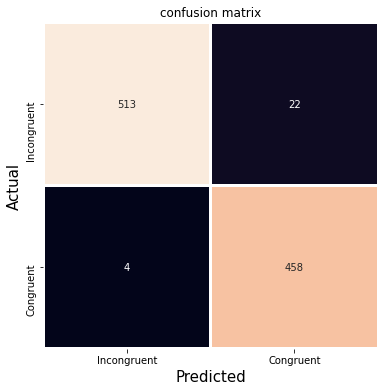

In [92]:
# plotting graph for confusion matrix
cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Incongruent','Congruent'], yticklabels = ['Incongruent','Congruent'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='black', fontsize=15)
plt.ylabel('Actual', color='black', fontsize=15);

In [93]:
confusion_matrix(test_y, pred, labels=(1,0)).ravel()

array([458,   4,  22, 513], dtype=int64)

In [94]:
tp, fn, fp, tn = confusion_matrix(test_y, pred, labels=(1,0)).ravel()

In [95]:
precision = tp/(tp+fp)
precision

0.9541666666666667

In [96]:
from sklearn.metrics import recall_score
recall_score(test_y, pred)

0.9913419913419913

In [97]:
from sklearn.metrics import f1_score
f1_score(test_y, pred)

0.9723991507430998

In [98]:
# accuracy of the model after applying the IT
accuracy_score(test_y, pred)

0.9739217652958877

<ipython-input-99-ee9a1527a465>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


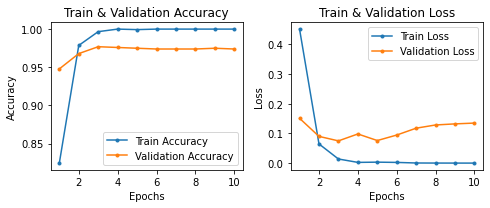

In [99]:
def plot_loss_epochs(history):
    epochs = np.arange(1,len(history.history['accuracy']) + 1,1)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    fig , ax = plt.subplots(1,2, figsize=(7,3))
    ax[0].plot(epochs , train_acc , '.-' , label ='Train Accuracy')
    ax[0].plot(epochs , val_acc , '.-' , label = 'Validation Accuracy')
    ax[0].set_title('Train & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs , train_loss , '.-', label ='Train Loss')
    ax[1].plot(epochs , val_loss , '.-', label ='Validation Loss')
    ax[1].set_title('Train & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    fig.tight_layout()
    fig.show()

plot_loss_epochs(history)

In [33]:
import re

# Vectorization technique TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Model libraries
from sklearn.svm import SVC

#Accuracy measuring library
from sklearn.metrics import accuracy_score

In [34]:
df = pd.read_csv('C:/Users/ASUS_AMZAD/Desktop/Major/Dataset1/data.csv')
df.head()

URLs  \
0  http://www.bbc.com/news/world-us-canada-414191...   
1  https://www.reuters.com/article/us-filmfestiva...   
2  https://www.nytimes.com/2017/10/09/us/politics...   
3  https://www.reuters.com/article/us-mexico-oil-...   
4  http://www.cnn.com/videos/cnnmoney/2017/10/08/...   

                                            Headline  \
0         Four ways Bob Corker skewered Donald Trump   
1  Linklater's war veteran comedy speaks to moder...   
2  Trump’s Fight With Corker Jeopardizes His Legi...   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...   
4        Jason Aldean opens 'SNL' with Vegas tribute   

                                                Body  Label  
0  Image copyright Getty Images\nOn Sunday mornin...      1  
1  LONDON (Reuters) - “Last Flag Flying”, a comed...      1  
2  The feud broke into public view last week when...      1  
3  MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1  
4  Country singer Jason Aldean, who was performin...      1

In [35]:
df = data.copy()

NameError: name 'data' is not defined

In [36]:
df['Body'] = df['Body'].fillna('')

In [37]:
df['News'] = df['Headline']+df['Body']

In [38]:
df.head()

URLs  \
0  http://www.bbc.com/news/world-us-canada-414191...   
1  https://www.reuters.com/article/us-filmfestiva...   
2  https://www.nytimes.com/2017/10/09/us/politics...   
3  https://www.reuters.com/article/us-mexico-oil-...   
4  http://www.cnn.com/videos/cnnmoney/2017/10/08/...   

                                            Headline  \
0         Four ways Bob Corker skewered Donald Trump   
1  Linklater's war veteran comedy speaks to moder...   
2  Trump’s Fight With Corker Jeopardizes His Legi...   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...   
4        Jason Aldean opens 'SNL' with Vegas tribute   

                                                Body  Label  \
0  Image copyright Getty Images\nOn Sunday mornin...      1   
1  LONDON (Reuters) - “Last Flag Flying”, a comed...      1   
2  The feud broke into public view last week when...      1   
3  MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1   
4  Country singer Jason Aldean, who was performin...      1   

                                                News  
0  Four ways Bob Corker skewered Donald TrumpImag...  
1  Linklater's war veteran comedy speaks to moder...  
2  Trump’s Fight With Corker Jeopardizes His Legi...  
3  Egypt's Cheiron wins tie-up with Pemex for Mex...  
4  Jason Aldean opens 'SNL' with Vegas tributeCou...

In [39]:
df.columns

Index(['URLs', 'Headline', 'Body', 'Label', 'News'], dtype='object')

In [40]:
features_dropped = ['Website','Text']
df = df.drop(features_dropped, axis =1)

KeyError: "['Website' 'Text'] not found in axis"

In [149]:
df.columns

Index(['Headline', 'Body', 'Label', 'News'], dtype='object')

In [150]:
ps = PorterStemmer()
def wordopt(text):
    text = re.sub('[^a-zA-Z]', ' ',text)
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    return text

In [151]:
df['News'] = df['News'].apply(wordopt)

In [152]:
df.head()

Headline  \
0         Four ways Bob Corker skewered Donald Trump   
1  Linklater's war veteran comedy speaks to moder...   
2  Trump’s Fight With Corker Jeopardizes His Legi...   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...   
4        Jason Aldean opens 'SNL' with Vegas tribute   

                                                Body  Label  \
0  Image copyright Getty Images\nOn Sunday mornin...      1   
1  LONDON (Reuters) - “Last Flag Flying”, a comed...      1   
2  The feud broke into public view last week when...      1   
3  MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1   
4  Country singer Jason Aldean, who was performin...      1   

                                                News  
0  four way bob corker skewer donald trumpimag co...  
1  linklat war veteran comedi speak modern americ...  
2  trump fight corker jeopard legisl agendath feu...  
3  egypt cheiron win tie pemex mexican onshor oil...  
4  jason aldean open snl vega tributecountri sing...

In [153]:
X = df['News']
Y = df['Label']

#Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [154]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [155]:
svm_model = SVC(kernel='linear')

svm_model.fit(xv_train,y_train)

svm_y_pred = svm_model.predict(xv_test)

In [156]:
# As SVM is able to provide best results - SVM will be used to check the news liabilit
def fake_news_det(news):
    input_data = {"text":[news]}
    new_def_test = pd.DataFrame(input_data)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    #print(new_x_test)
    vectorized_input_data = vectorization.transform(new_x_test)
    prediction = svm_model.predict(vectorized_input_data)
    
    if prediction == 1:
        print("Congruent")
    else:
        print("Incongruent")

In [157]:
fake_news_det("""The second Covid-19 wave in India is now on the "downswing," the Centre said on Thursday, highlighting that the current number of active cases is still "very high" and advised states and Union territories (UTs) to not let down their guards.""")

Congruent


In [159]:
fake_news_det("""North Korea's Other Threat: Why EMP Becomes An Extinction Level Event""")


Incongruent


In [160]:
fake_news_det("JetNation FanDuel League; Week 4 of readers think this story is Fact. Add your two cents.(Before Its News)Our FanDuel league is back again this week. Here are the details:$900 in total prize money. $250 to the winner. $10 to enter.Remember this is a one week league, pick your lineup against the salary cap and next week if you want to play again you can pick a completely different lineup if you want.Click this link to enter — http://fanduel.com/JetNation You can discuss this with other NY Jets fans on the Jet Nation message board. Or visit of on Facebook.Source: http://www.jetnation.com/2017/09/27/jetnation-fanduel-league-week-4/")


Incongruent
